In [100]:
import math 
import torch
import os
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
# Make plots inline
# %matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

X_tensor = torch.randn(1000)
X_tensor_arr = X_tensor.detach().numpy()
X_tensor_arr.sort()
X_tensor = torch.tensor(X_tensor_arr)
min_x = torch.min(X_tensor).detach().numpy()
max_x = torch.max(X_tensor).detach().numpy()
inducing_points = torch.tensor(np.random.randn(150) * 10)



In [101]:
#!/usr/bin/env python3
class SoRKernel(gpytorch.kernels.Kernel):
    def __init__(self, base_kernel, inducing_points, likelihood, active_dims=None):
        super(SoRKernel, self).__init__(active_dims=active_dims)
        self.base_kernel = base_kernel
        self.likelihood = likelihood

        if inducing_points.ndimension() == 1:
            inducing_points = inducing_points.unsqueeze(-1)
        if inducing_points.ndimension() != 2:
            raise RuntimeError("Inducing points should be 2 dimensional")
        self.register_parameter(name="inducing_points", parameter=torch.nn.Parameter(inducing_points))
        self.register_added_loss_term("inducing_point_loss_term")

    def train(self, mode=True):
        if hasattr(self, "_cached_kernel_mat"):
            del self._cached_kernel_mat
        return super(InducingPointKernel, self).train(mode)

    @property
    def _inducing_mat(self):
        if not self.training and hasattr(self, "_cached_kernel_mat"):
            return self._cached_kernel_mat
        else:
            res = gpytorch.lazy.delazify(self.base_kernel(self.inducing_points, self.inducing_points))
            if not self.training:
                self._cached_kernel_mat = res
            return res

    @property
    def _inducing_inv_root(self):
        if not self.training and hasattr(self, "_cached_kernel_inv_root"):
            return self._cached_kernel_inv_root
        else:
            chol = gpytorch.utils.cholesky.psd_safe_cholesky(self._inducing_mat, upper=True)
            eye = torch.eye(chol.size(-1), device=chol.device)
            inv_root = torch.trtrs(eye, chol)[0]

            res = inv_root
            if not self.training:
                self._cached_kernel_inv_root = res
            return res

    def _get_covariance(self, x1, x2):
        k_ux1 = gpytorch.lazy.delazify(self.base_kernel(x1, self.inducing_points))
        if torch.equal(x1, x2):
            covar = gpytorch.lazy.RootLazyTensor(k_ux1.matmul(self._inducing_inv_root))

            # Diagonal correction for predictive posterior
#             correction = (self.base_kernel(x1, x2, diag=True) - covar.diag()).clamp(0, math.inf)
#             covar = gpytorch.lazy.PsdSumLazyTensor(covar, gpytorch.lazy.DiagLazyTensor(correction))
        else:
            k_ux2 = gpytorch.lazy.delazify(self.base_kernel(x2, self.inducing_points))
            covar = gpytorch.lazy.MatmulLazyTensor(
                k_ux1.matmul(self._inducing_inv_root), k_ux2.matmul(self._inducing_inv_root).transpose(-1, -2)
            )

        return covar

    def _covar_diag(self, inputs):
        if inputs.ndimension() == 1:
            inputs = inputs.unsqueeze(1)

        # Get diagonal of covar
        covar_diag = gpytorch.lazy.delazify(self.base_kernel(inputs, diag=True))
        return gpytorch.lazy.DiagLazyTensor(covar_diag)

    def forward(self, x1, x2, diag=False, **kwargs):
        covar = self._get_covariance(x1, x2)

        if self.training:
            if not torch.equal(x1, x2):
                raise RuntimeError("x1 should equal x2 in training mode")
            zero_mean = torch.zeros_like(x1.select(-1, 0))
            new_added_loss_term = gpytorch.mlls.InducingPointKernelAddedLossTerm(
                gpytorch.distributions.MultivariateNormal(zero_mean, self._covar_diag(x1)),
                gpytorch.distributions.MultivariateNormal(zero_mean, covar),
                self.likelihood,
            )
            self.update_added_loss_term("inducing_point_loss_term", new_added_loss_term)

        if diag:
            return covar.diag()
        else:
            return covar

    def num_outputs_per_input(self, x1, x2):
        return self.base_kernel.num_outputs_per_input(x1, x2)

In [102]:
exact_gp_cov_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
exact_GP_cov = exact_gp_cov_module(X_tensor).evaluate().detach().numpy()

grid_size = 40
kiss_40_GP_cov_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1)
kiss_40_GP_cov = kiss_40_GP_cov_module(X_tensor).evaluate().detach().numpy()


grid_size = 150
kiss_150_GP_cov_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1)
kiss_150_GP_cov = kiss_150_GP_cov_module(X_tensor).evaluate().detach().numpy()

likelihood = gpytorch.likelihoods.GaussianLikelihood()

FITC_150_GP_cov_module = gpytorch.kernels.InducingPointKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            inducing_points=inducing_points,
            likelihood=likelihood).float()

FITC_150_GP_cov = FITC_150_GP_cov_module(X_tensor).evaluate().detach().numpy()

FITC_150_GP_cov_module = gpytorch.kernels.InducingPointKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            inducing_points=inducing_points,
            likelihood=likelihood).float()

FITC_150_GP_cov = FITC_150_GP_cov_module(X_tensor).evaluate().detach().numpy()



SoR_150_GP_module = SoRKernel(base_kernel=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), inducing_points=inducing_points, likelihood=likelihood).float()
SoR_150_GP_cov = SoR_150_GP_module(X_tensor).evaluate().detach().numpy()



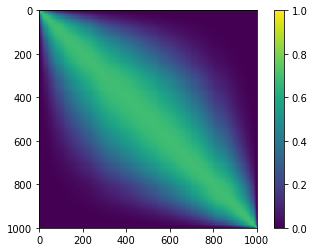

In [103]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(exact_GP_cov, interpolation='nearest',vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

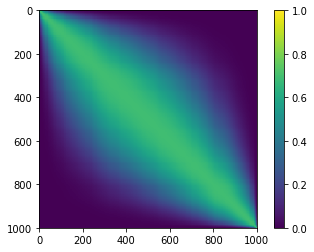

In [104]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(kiss_40_GP_cov, interpolation='nearest',vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

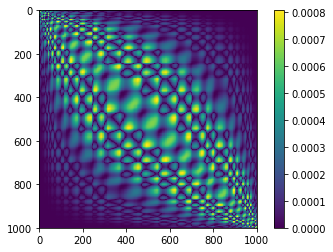

In [105]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(kiss_40_GP_cov-exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()

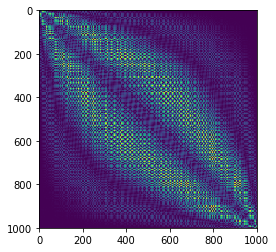

In [106]:
plt.imshow(abs(kiss_150_GP_cov-exact_GP_cov), interpolation='nearest')
plt.show()

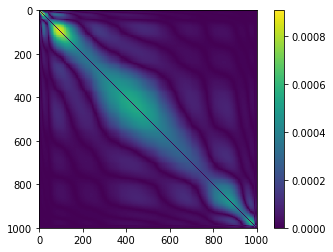

In [107]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(FITC_150_GP_cov-exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()


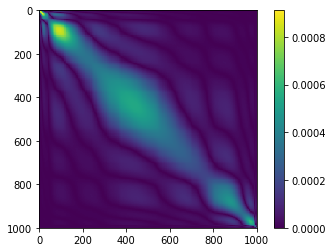

In [108]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(SoR_150_GP_cov-exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()

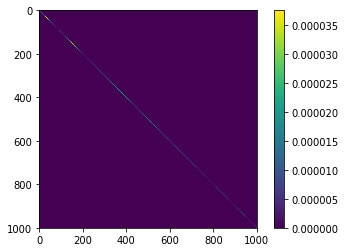

In [98]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(SoR_150_GP_cov-FITC_150_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()